In [2]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from scipy import signal
import librosa as lr
import librosa.feature as lrf
import sklearn as sk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from scipy.signal import welch
from sklearn.linear_model import Lasso
import scipy.stats as stats
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
import pywt
from pywt import *
from scipy.signal import periodogram
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert


In [3]:
np.random.seed(100)

In [4]:
data_dict = scipy.io.loadmat('dataset.mat')

In [5]:
subjects = data_dict["subindex"]
states = data_dict["substate"]
data = data_dict["EEGsample"]

In [74]:
subjects = pd.DataFrame(subjects)
states = pd.DataFrame(states)
#data = np.reshape(data,(60660,384))
#data = pd.DataFrame(data)
#data = data.to_numpy()

#CHANNEL DENEMECE


#data = data[:,[3, 4, 13, 14, 27, 28, 29],:]
#data_temp = np.concatenate((data[:,0,:],data[:,1,:],data[:,2,:],data[:,3,:],data[:,4,:],data[:,5,:],data[:,6,:],data[:,7,:],data[:,8,:],data[:,9,:],data[:,10,:],data[:,11,:],data[:,12,:],data[:,13,:],data[:,14,:],data[:,15,:],data[:,16,:],data[:,17,:],data[:,18,:],data[:,19,:],data[:,20,:],data[:,21,:],data[:,22,:],data[:,23,:],data[:,24,:],data[:,25,:],data[:,26,:],data[:,27,:],data[:,28,:],data[:,29,:]))
data_temp = np.concatenate((data[:,3,:],data[:,5,:],data[:,13,:],data[:,14,:],data[:,28,:]))
#data_temp = np.concatenate((data[:,28,:]))
#data_temp = data[:,5,:]
#data_temp = np.concatenate((data[:,0,:],data[:,1,:],data[:,2,:],data[:,3,:],data[:,4,:],data[:,5,:],data[:,6,:],data[:,7,:],data[:,8,:],data[:,9,:],data[:,10,:],data[:,11,:]))
data = data_temp

In [75]:
#BU FONKSİYON PERFORMANSI ARTTIRMADI SİLEBİLİRİZ GİBİ

def hjorth_parameters(eeg_signal):
    # Calculate the first derivative (slope) of the EEG signal
    diff_signal = np.diff(eeg_signal)
    
    # Calculate the variance (activity) of the original signal
    activity = np.var(eeg_signal)
    
    # Calculate the variance (activity) of the first derivative (slope)
    mobility = np.var(diff_signal)
    
    # Calculate the mobility parameter (square root of mobility divided by activity)
    mobility /= activity
    
    # Calculate the second derivative of the EEG signal
    diff2_signal = np.diff(diff_signal)
    
    # Calculate the complexity (square root of the mobility divided by the mobility of the first derivative)
    complexity = np.sqrt(mobility / (np.var(diff2_signal) / activity))
    
    return activity, mobility, complexity

In [76]:
def feature_extraction(signal):
    
    n_mfcc =5
    feature_vector = []
    extracted_features = []
    # Timbral Texture Features
    feature_vector.append([lrf.spectral_centroid(signal)]) # Spectral Centroid
    feature_vector.append([lrf.spectral_rolloff(signal)]) # Rolloff
    #feature_vector.append([lr.onset.onset_strength(signal)]) # Flux
    #feature_vector.append(lr.feature.zero_crossing_rate(signal)) # Zero Crossings
    feature_vector.append([[np.array(np.sum(np.abs(np.diff(np.sign(signal)))) / (2 * len(signal)))]])
    
    for mfcc in lrf.mfcc(signal, n_mfcc=n_mfcc): # First 5 MFCCs
        feature_vector.append([mfcc])
    
    for chroma in lrf.chroma_stft(signal, n_chroma=15): #chromagram
        feature_vector.append([chroma])

    n_mel = 10
    for mel in lr.power_to_db(lrf.melspectrogram(signal))[:n_mel, :] :
        feature_vector.append([mel])
    
    #feature_vector.append([np.mean(signal)]) #no
    #feature_vector.append([np.var(signal)]) #no
    #feature_vector.append([stats.skew(signal)]) #no
    #feature_vector.append([stats.kurtosis(signal)]) #no

    #activity, mobility, complexity = hjorth_parameters(signal) #no
    #feature_vector.append([activity]) #no
    #feature_vector.append([mobility]) #no
    #feature_vector.append([complexity]) #no

    #feature_vector.append([np.sqrt(np.mean(signal**2))]) #no


    
    wavelet = 'db4' #nasıl çalışıyor veya doğru mu b
    frequency_bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30,64)
}
    # Iterate over each frequency band
    band_powers = {}
    sampling_frequency = 128

    # Calculate the power spectral density (PSD) using Welch's method
    frequencies, psd = welch(signal, fs=sampling_frequency, nperseg=1024)

    # Iterate over each frequency band
    for band, (low_freq, high_freq) in frequency_bands.items():
        # Find indices corresponding to the specified frequency range
        band_indices = np.where((frequencies >= low_freq) & (frequencies < high_freq))
        # Integrate PSD within the band's frequency range to compute band power
        band_power = np.trapz(psd[band_indices], frequencies[band_indices])
        band_powers[band] = band_power
        feature_vector.append([[band_power]])
    
    feature_vector.append([[band_powers['gamma']/band_powers['beta']]])
    feature_vector.append([[band_powers['gamma']/band_powers['alpha']]])
    feature_vector.append([[band_powers['gamma']/band_powers['theta']]])
    feature_vector.append([[band_powers['gamma']/band_powers['delta']]])
    feature_vector.append([[band_powers['beta']/band_powers['alpha']]])
    feature_vector.append([[band_powers['beta']/band_powers['theta']]])
    feature_vector.append([[band_powers['beta']/band_powers['delta']]])
    feature_vector.append([[band_powers['alpha']/band_powers['theta']]])
    feature_vector.append([[band_powers['alpha']/band_powers['delta']]])
    feature_vector.append([[band_powers['theta']/band_powers['delta']]])
    
    '''
    [cA5, cD5, cD4, cD3, cD2, cD1] = wavedec(signal, 'db1', level=5)
    coeffs = [cA5, cD5, cD4, cD3, cD2, cD1]
    db1 = pywt.Wavelet('db1')
    
    re0 = pywt.waverec([coeffs[0]], db1)
    re1 = pywt.waverec([coeffs[1]], db1)
    re2 = pywt.waverec([coeffs[2]], db1)
    re3 = pywt.waverec([coeffs[3]], db1)
    re4 = pywt.waverec([coeffs[4]], db1)
    re5 = pywt.waverec([coeffs[5]], db1)

    re0_p = np.sum(np.power(re0,2)/len(re0))
    re1_p = np.sum(np.power(re1,2)/len(re1))
    re2_p = np.sum(np.power(re2,2)/len(re2))
    re3_p = np.sum(np.power(re3,2)/len(re3))
    re4_p = np.sum(np.power(re4,2)/len(re4))
    re5_p = np.sum(np.power(re5,2)/len(re5))
    
    feature_vector.append([[re0_p]])
    feature_vector.append([[re1_p]])
    feature_vector.append([[re2_p]])
    feature_vector.append([[re3_p]])
    feature_vector.append([[re4_p]])
    feature_vector.append([[re5_p]])
    
    feature_vector.append([[re5_p/re4_p]])
    feature_vector.append([[re5_p/re3_p]])
    feature_vector.append([[re5_p/re2_p]])
    feature_vector.append([[re5_p/re1_p]])
    feature_vector.append([[re5_p/re0_p]])
    feature_vector.append([[re4_p/re3_p]])
    feature_vector.append([[re4_p/re2_p]])
    feature_vector.append([[re4_p/re1_p]])
    feature_vector.append([[re4_p/re0_p]])
    feature_vector.append([[re3_p/re2_p]])
    feature_vector.append([[re3_p/re1_p]])
    feature_vector.append([[re3_p/re0_p]])
    feature_vector.append([[re2_p/re1_p]])
    feature_vector.append([[re2_p/re0_p]])
    feature_vector.append([[re1_p/re0_p]])
    '''
    '''
    # Pitch Content Features
    n_mel = 10
    n_tonnetz = 6
    #feature_vector.append(lr.beat.tempo(signal)) # Tempo #bu kötü yapiyor
    
    for chroma in lrf.chroma_stft(signal, n_chroma=12): #bu iyi yapiyor
        feature_vector.append([chroma])
        
    for mel in lr.power_to_db(lrf.melspectrogram(signal))[:n_mel, :] : #bu iyi
        feature_vector.append([mel])
    
    #for tonal in lrf.tonnetz(signal)[:n_tonnetz, :] : #daha kötü gibi
    #    feature_vector.append(tonal)
    '''
    for feature in feature_vector:
        extracted_features.append(feature)
        #extracted_features.append(np.mean(feature))
        #extracted_features.append(np.std(feature)) 
    
    '''    
    # Rhythymic Content Features
    peaks = -np.sort(-lr.onset.onset_strength(signal, sr = 128))
    A0 = peaks[0]
    A1 = peaks[1]
    RA = A1/A0    
    
    extracted_features.append(np.mean(lrf.tempogram(signal)))
    extracted_features.append(A0)
    extracted_features.append(A1)
    extracted_features.append(RA)
    '''
    return np.array(extracted_features)

In [77]:
import time

start = time.time()

boncuk = []
for i in range(data.shape[0]):
    powers = feature_extraction(data[i,:])
    boncuk.append(powers)

end = time.time()
print(end-start) 
#zaman olc

183.22886896133423


In [78]:
boncuk1 = np.array(boncuk)

In [79]:
boncuk1 = boncuk1[:,:,0,0]

In [80]:
df = pd.DataFrame.from_dict(boncuk1)

In [81]:
df.to_csv("eeg_featuresold.csv")

In [6]:
df = pd.read_csv('eeg_features_channeltest.csv',float_precision='round_trip')
df = df.drop('Unnamed: 0', axis=1)

In [46]:
df1 = pd.read_csv('eeg_features_channeltest.csv',float_precision='round_trip')


In [47]:
df1 = df1.drop('Unnamed: 0', axis=1)

In [48]:
df1 = df1.drop('channels', axis=1)
df1 = df1.drop('label', axis=1)


In [49]:
df.equals(df1)

False

In [50]:
X = df1
y = states
y = np.concatenate((y,y,y,y,y))

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)
display_labels = ["focused","drowsy"]

# apply normalization after splitting to avoid leakage
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [52]:
# Encode the genre labels
'''
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

#y = y.reset_index(drop=True)

pca = PCA(n_components = 0.999)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
#X = dataPCA
variance = pd.DataFrame(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))
'''

'\nfrom sklearn.decomposition import PCA\nfrom sklearn.preprocessing import LabelEncoder, StandardScaler\n\n#y = y.reset_index(drop=True)\n\npca = PCA(n_components = 0.999)\nX_train = pca.fit_transform(X_train)\nX_test = pca.transform(X_test)\n#X = dataPCA\nvariance = pd.DataFrame(pca.explained_variance_ratio_)\nprint(pca.explained_variance_ratio_)\nprint(np.sum(pca.explained_variance_ratio_))\n'

In [53]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.4f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.4f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.8633
Accuracy of K-NN classifier on test set: 0.7903


KNN Matrix


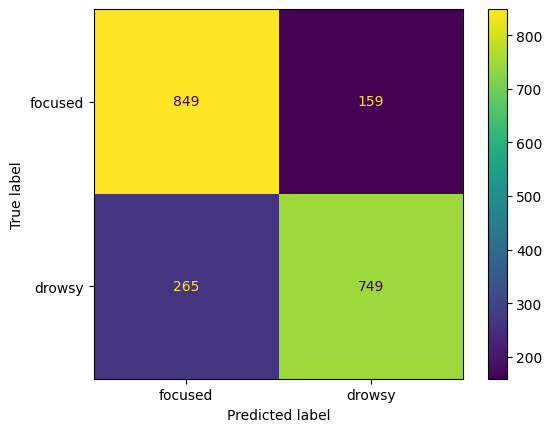

In [54]:
knn_cm = confusion_matrix(y_test, knn.predict(X_test))
knn_disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm,display_labels=display_labels)
print("KNN Matrix")
knn_disp.plot()

In [55]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
print('Accuracy of RandomForestClassifier classifier on training set: {:.4f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy of RandomForestClassifier classifier on test set: {:.4f}'
     .format(rf.score(X_test, y_test)))

Accuracy of RandomForestClassifier classifier on training set: 1.0000
Accuracy of RandomForestClassifier classifier on test set: 0.7898


DT Matrix


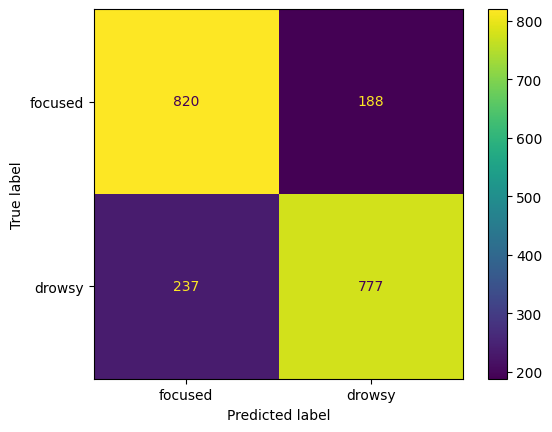

In [56]:
rf_cm = confusion_matrix(y_test, rf.predict(X_test))
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm,display_labels=display_labels)
print("DT Matrix")
rf_disp.plot()

In [57]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(loss='log_loss',n_estimators=300, learning_rate=0.1, max_depth=10, random_state=1).fit(X_train, y_train)
print('Accuracy of GradientBoostingClassifier on training set: {:.8f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GradientBoostingClassifier on test set: {:.8f}'
     .format(clf.score(X_test, y_test)))

Accuracy of GradientBoostingClassifier on training set: 1.00000000
Accuracy of GradientBoostingClassifier on test set: 0.81157270


DT Matrix


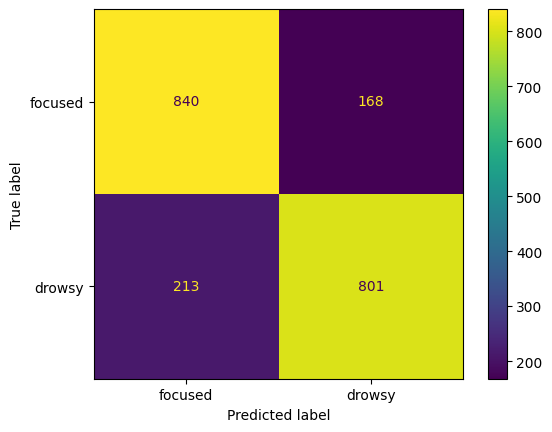

In [58]:
clf_cm = confusion_matrix(y_test, clf.predict(X_test))
clf_disp = ConfusionMatrixDisplay(confusion_matrix=clf_cm,display_labels=display_labels)
print("DT Matrix")
clf_disp.plot()

In [59]:
print(classification_report(y_test, clf.predict(X_test), labels=[0,1]))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1008
           1       0.83      0.79      0.81      1014

    accuracy                           0.81      2022
   macro avg       0.81      0.81      0.81      2022
weighted avg       0.81      0.81      0.81      2022



In [60]:
print("XG BOOST STATS")
sensitivity = recall_score(y_test, clf.predict(X_test))
print("Sensitivity (Recall):", sensitivity)

precision = precision_score(y_test, clf.predict(X_test))
print("Precision:", precision)

accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy (Recall):", accuracy)
    
f1 = f1_score(y_test, clf.predict(X_test))
print("f1_score:", f1)

fpr, tpr, thresholds = roc_curve(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
print("AUC:", auc)

logloss = log_loss(y_test, clf.predict(X_test))
print("logloss:", logloss)

XG BOOST STATS
Sensitivity (Recall): 0.7899408284023669
Precision: 0.826625386996904
Accuracy (Recall): 0.8115727002967359
f1_score: 0.8078668683812404
AUC: 0.8116370808678501
logloss: 6.508114806542652


In [61]:
import sklearn as sk
from sklearn.neural_network import MLPClassifier
NN = MLPClassifier(activation='relu',solver='adam', alpha=1e-2, learning_rate='adaptive', max_iter=1000000, hidden_layer_sizes=(60,2), random_state=1)
NN.fit(X_train, y_train)
print('Accuracy of NN classifier on training set: {:.4f}'
     .format(NN.score(X_train, y_train)))
print('Accuracy of NN classifier on test set: {:.4f}'
     .format(NN.score(X_test, y_test)))

Accuracy of NN classifier on training set: 0.9143
Accuracy of NN classifier on test set: 0.7493


In [62]:
from sklearn.svm import SVC
svm = SVC(C=1.0, kernel='rbf', degree=10, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=1)
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.4f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.4f}'
     .format(svm.score(X_test, y_test)))



Accuracy of SVM classifier on training set: 0.8122
Accuracy of SVM classifier on test set: 0.7829


In [63]:
df1 = pd.read_csv('1.csv')
df2 = pd.read_csv('2.csv')

FileNotFoundError: [Errno 2] No such file or directory: '1.csv'

In [ ]:
df1.head()      

,Unnamed: 0,0,1
0,0,3590.459896,6675.292969
1,1,3752.577012,6998.291016
2,2,3647.662002,7105.957031
3,3,3649.478683,6901.391602
4,4,3782.088471,7116.723633


In [ ]:
df2.head()

,Unnamed: 0,channels,spc_cnt,spc_roff,label
0,0,F3,3590.459896,6675.292969,0
1,1,F3,3752.577012,6998.291016,0
2,2,F3,3647.662002,7105.957031,0
3,3,F3,3649.478683,6901.391602,0
4,4,F3,3782.088471,7116.723633,0


In [ ]:
df1.insert(loc = 4, column = 'label', value = df2['label'])

IndexError: index 4 is out of bounds for axis 0 with size 3

In [ ]:
df2.columns = df1.columns


In [ ]:
df2.to_csv('newcsv.csv')

In [ ]:
df1.equals(df2)

True

In [ ]:
df2 = df2.drop('label', axis = 1)

In [ ]:
print('Accuracy of GradientBoostingClassifier on training set: {:.8f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GradientBoostingClassifier on test set: {:.8f}'
     .format(clf.score(X_test, y_test)))


Accuracy of GradientBoostingClassifier on training set: 1.00000000
Accuracy of GradientBoostingClassifier on test set: 0.81602374
